# JHU covid-19 daily data processing 

Test and update functions for JHU data analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import glob
import os
 
import matplotlib.ticker as mticker
import matplotlib.dates as mdates 

from datetime import timedelta 
import datetime
import pytz
from tzwhere import tzwhere  


from matplotlib.dates import date2num       #-->Update

import matplotlib
from matplotlib import cm


import os
import sys
base_path = os.path.dirname( os.getcwd()  )   
sys.path.append(base_path ) 
import JHU_dataprocessing_functions as dp
import JHU_plotting_functions as jp 

# general parameters 

In [3]:
full_w = (12,7)
half_w = (6,4)

# Load daily reports 

In [4]:
path = r'D:\Code_projects\Covid19_analysis\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports'

daily_reports = glob.glob(path + '\*.csv') 
df = pd.DataFrame()
for file in daily_reports :
    df_temp = pd.read_csv( file, index_col=None, header=0) 
    df = df.append(df_temp, sort=True) 

df.tail()

,Active,Admin2,Combined_Key,Confirmed,Country/Region,Country_Region,Deaths,FIPS,Last Update,Last_Update,Lat,Latitude,Long_,Longitude,Province/State,Province_State,Recovered
2997,248.0,NaN,West Bank and Gaza,308.0,NaN,West Bank and Gaza,2.0,NaN,NaN,2020-04-13 23:07:34,31.952200,NaN,35.233200,NaN,NaN,NaN,58.0
2998,6.0,NaN,Western Sahara,6.0,NaN,Western Sahara,0.0,NaN,NaN,2020-04-13 23:07:34,24.215500,NaN,-12.885800,NaN,NaN,NaN,0.0
2999,1.0,NaN,Yemen,1.0,NaN,Yemen,0.0,NaN,NaN,2020-04-13 23:07:34,15.552727,NaN,48.516388,NaN,NaN,NaN,0.0
3000,13.0,NaN,Zambia,45.0,NaN,Zambia,2.0,NaN,NaN,2020-04-13 23:07:34,-13.133897,NaN,27.849332,NaN,NaN,NaN,30.0
3001,14.0,NaN,Zimbabwe,17.0,NaN,Zimbabwe,3.0,NaN,NaN,2020-04-13 23:07:34,-19.015438,NaN,29.154857,NaN,NaN,NaN,0.0


# adjust column names and use only relevant columns

In [5]:
# convert different datetimes to same datetime column 
df['Last Update'] = pd.to_datetime(df['Last Update']   )
df['Last_Update'] = pd.to_datetime(df['Last_Update']   )   #  
cond = df['Last_Update'].isnull()
df['Last Update'] = df['Last Update'].where(cond, df['Last_Update'] ) 
df['Datetime']= pd.to_datetime(df['Last Update'] , unit='D'   ) 
df['Date'] = df['Datetime'].dt.date

cond = df['Country_Region'].isnull()
df['Country/Region'] = df['Country/Region'].where(cond, df['Country_Region'] ) 

cond = df['Province_State'].isnull()
df['Province/State'] = df['Province/State'].where(cond, df['Province_State'] ) 
 
col_order = ['Date','Country/Region','Province/State','Active','Confirmed','Deaths','Recovered','Combined_Key' ]
df = df[col_order]

df.tail()

,Date,Country/Region,Province/State,Active,Confirmed,Deaths,Recovered,Combined_Key
2997,2020-04-13,West Bank and Gaza,NaN,248.0,308.0,2.0,58.0,West Bank and Gaza
2998,2020-04-13,Western Sahara,NaN,6.0,6.0,0.0,0.0,Western Sahara
2999,2020-04-13,Yemen,NaN,1.0,1.0,0.0,0.0,Yemen
3000,2020-04-13,Zambia,NaN,13.0,45.0,2.0,30.0,Zambia
3001,2020-04-13,Zimbabwe,NaN,14.0,17.0,3.0,0.0,Zimbabwe


# process columns 

In [6]:
bool_US = df['Country/Region'] =='US' 
# bool_last = df['Date'] > datetime.datetime(2020,3,22).date() 
bool_last = df['Date'] > datetime.datetime(2020,3,23).date()
 
df_US = df[bool_US & bool_last ].copy() 
 
df_US =  df_US.groupby(['Province/State','Date']).sum().reset_index()  
df_US = df_US.sort_values( by=['Province/State','Date']).reset_index(drop=True)  
 
df_US.head()
 

,Province/State,Date,Active,Confirmed,Deaths,Recovered
0,Alabama,2020-03-24,0.0,242.0,0.0,0.0
1,Alabama,2020-03-25,0.0,381.0,1.0,0.0
2,Alabama,2020-03-26,0.0,517.0,1.0,0.0
3,Alabama,2020-03-27,0.0,587.0,4.0,0.0
4,Alabama,2020-03-28,0.0,694.0,4.0,0.0


# transform state geometry 

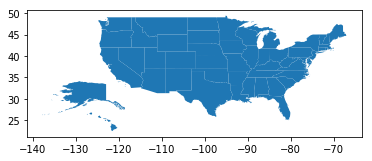

In [56]:
import geopandas as gpd

    
data_path = os.path.join(  base_path,  'geo_data\states.shp' )  
US = gpd.read_file(data_path)
AKratio = 0.4;  # scales Alaska 
HIratio = 1.3 # scales Hawai 
AKtrans = [25,-33] # moves Alaska south and east 
HItrans = [34,4] # moves Hawaii east and north 
 
import shapely.affinity as shp

# get original polygons
bool_alaska = US['STATE_NAME'] == 'Alaska'
alaska_object = US.loc[bool_alaska,'geometry']
alaska_geom = US.loc[bool_alaska,'geometry'].iloc[0] 

alaska_moved = shp.translate(alaska_geom, AKtrans[0], AKtrans[1])  
centroid = alaska_moved.centroid
alaska_scaled = shp.scale( alaska_moved, xfact=AKratio, yfact=AKratio, origin=centroid)
# US['geometry'][50] =  alaska_scaled
alaska_object.iloc[0] = alaska_scaled
US.loc[bool_alaska,'geometry'] = alaska_object

# # US['geometry'][50] =  alaska_scaled

bool_hawaii = US['STATE_NAME'] == 'Hawaii'
hawaii_obj = US.loc[bool_hawaii,'geometry']
hawaii_geom = hawaii_obj.iloc[0]

hawaii_moved = shp.translate(hawaii_geom, HItrans[0], HItrans[1])  
centroid = hawaii_moved.centroid
hawaii_scaled = shp.scale( hawaii_moved, xfact=HIratio, yfact=HIratio, origin=centroid)
hawaii_obj.iloc[0] = hawaii_scaled

US.loc[bool_hawaii,'geometry'] =  hawaii_obj

  
 
US.plot()
 

In [51]:
# type( US.loc[bool_alaska,'geometry']  )
alaska_obj = US.loc[bool_alaska,'geometry']

geom = alaska_obj.iloc[0]

alaska_obj.iloc[0] = geom
alaska_obj 
# US['geometry'] 

50    (POLYGON ((-161.3337853466416 58.7332483821643...
Name: geometry, dtype: object

In [10]:
();

df_US

#     bool_US = US['STATE_NAME'] == state 
# #     US.loc[bool_US,'Cases'] = latest_cases  
#     US.loc[bool_US,'Cases'] = np.log(latest_cases+1) 

US.head()



# states = US['STATE_NAME'].tolist()
states = df_US['Province/State'].unique().tolist()
dates = df_US['Date'].unique() 

for state in states: 
#     print(state)
    bool_state = df_US['Province/State'] == state 
    bool_date = df_US['Date'] == dates[-1]
    bool_prior = df_US['Date'] == dates[-7] 
    if (bool_state & bool_date).sum() > 0:
        now_cases = df_US[bool_state & bool_date ]['Confirmed'].iloc[0]
        prior_cases = df_US[bool_state & bool_prior ]['Confirmed'].iloc[0]
        latest_cases = (now_cases-prior_cases)/7
    else:
        latest_cases = 0 
         
    df_US.loc[bool_state ,'Cases'] = np.log(latest_cases + 2)
    
    
# US['Cases'] = 0 
df_US = df_US.rename(columns={'Province/State':'STATE_NAME'}) 

df_US = df_US[bool_date] 
US= pd.merge(US, df_US, how='left', on=['STATE_NAME'])
df_US.head()  

,STATE_NAME,Date,Active,Confirmed,Deaths,Recovered,Cases
20,Alabama,2020-04-13,3635.0,3734.0,99.0,0.0,5.418637
41,Alaska,2020-04-13,269.0,277.0,8.0,0.0,2.410799
69,Arizona,2020-04-13,3583.0,3705.0,122.0,0.0,4.798149
90,Arkansas,2020-04-13,1381.0,1410.0,29.0,0.0,4.223701
111,California,2020-04-13,23216.0,23931.0,715.0,0.0,6.848005


# plot US map

Text(-135, 22, 'Updated 2020-04-13')

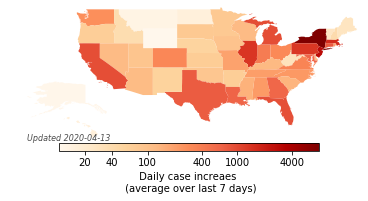

In [11]:
# fig, ax = plt.subplots(1,1 ,figsize=(15,8))
fig, ax = plt.subplots(1,1 ,figsize=half_w )


wp = US.plot(column='Cases', ax=ax, cmap='OrRd'   );

wp.set_xbound(-135,-66)
wp.set_ybound(20,49.5)  
 

vmin =    US['Cases'].min()
vmax =  ( US['Cases'].max() )
 
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax)) 
 



# fake up the array of the scalar mappable. Urgh...
sm._A = []
cax = fig.add_axes([0.2, 0.25, 0.6, 0.03])
cb = fig.colorbar(sm, cax=cax, orientation='horizontal')
 

# tick_array =  [1,10,100,1000,10000,10000] 
tick_array =  [20,40,100,400,1000,4000,10000 ] 
log_cases = np.log( tick_array  )  
cb.set_ticks( log_cases ) 
cb.set_ticklabels( tick_array) 
cb.set_label(' Daily case increaes  \n (average over last 7 days)')

ax.axis("off")


ax.annotate('Updated '+str( df_US['Date'].iloc[-1]), 
            [-135,22 ], color=[.3,.3,.3], style='italic',fontsize=8)
 